In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2data/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2data/Training.csv',delimiter=',',skip_header=True)

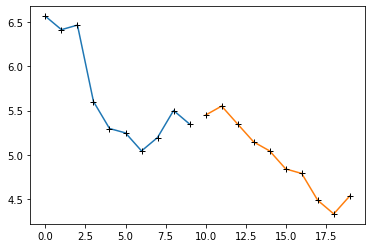

In [5]:
# Defining split sizes 

test_size = 1152
train_size = len(X) - test_size

train_raw = X[:train_size]
test_raw = X[train_size:]

train_raw.shape, test_raw.shape

plt.plot(figsize=(20,5))
plt.plot(range(10),train_raw[-10:,0])
plt.plot(range(10,20),test_raw[:10,0])
plt.plot(range(0,20),X[train_size-10:train_size+10,0],'+k')

In [6]:
# Pre-processing

train_max = train_raw.max(axis=0)
train_min = train_raw.min(axis=0)

X_mean = train_raw.mean(axis=0)
X_std = train_raw.std(axis=0)

train_scaled = (train_raw-train_min)/(train_max-train_min)
test_scaled = (test_raw-train_min)/(train_max-train_min)

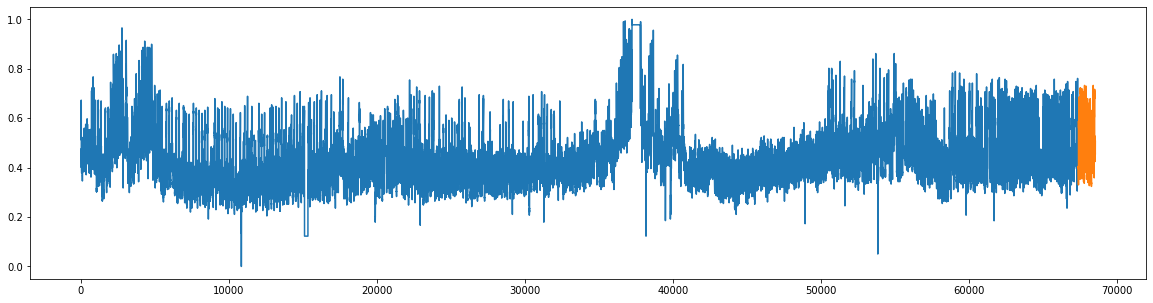

In [7]:
i=0
plt.figure(figsize=(20,5))
plt.plot(train_scaled[:,i])
plt.plot(range(train_size, train_size+test_size),test_scaled[:,i])

In [8]:
# generate X, y
def extract_sequences(array,sequence_length = 200,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [9]:
def build_lstm_seq2seq_attention(input_shape):

    n_units=512
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    b1 = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(input_layer)
    b1 = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(b1)

    encoder_x,encoder_h,encoder_c = tfkl.LSTM(units=n_units, return_sequences=True,return_state=True)(b1)
    
    encoder_h = tfkl.LayerNormalization()(encoder_h)
    encoder_c = tfkl.LayerNormalization()(encoder_c)
    decoder_in = tfkl.RepeatVector(1)(encoder_h)
    
    decoder_x = tfkl.LSTM(units=n_units, return_sequences=True,return_state=False)(decoder_in,initial_state=[encoder_h,encoder_c])
    attention = tfkl.Dot(axes=[2,2])([decoder_x, encoder_x])
    attention = tfkl.Activation('softmax')(attention)
    context = tfkl.Dot(axes=[2,1])([attention,encoder_x])
    context = tfkl.LayerNormalization()(context)
    
    concatenated_c = tfkl.Concatenate()([context,decoder_x]) 
    concatenated_c = tfkl.Flatten()(concatenated_c)
    output_layer = tfkl.Dense(7)(concatenated_c)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [10]:
def build_convlstm(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    b1 = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(input_layer)
    b1 = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(b1)
    b1_out = tfkl.MaxPool1D()(b1)
    
    
    b2 = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(b1_out)
    b2 = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(b2)
    #b2_out = tfkl.MaxPool1D()(b2)
    b2_out = tfkl.GlobalAveragePooling1D()(b2)
    #c_1 = tfkl.Concatenate()([tfkl.Flatten()(b1_out),tfkl.Flatten()(b2_out),tfkl.Flatten()(b3_out)])
    o_2 = tfkl.Dense(7)(b2_out)

    
    lstm_1 = tfkl.LSTM(units=512,return_sequences=False, return_state=False)(input_layer)
    o_1 = tfkl.Dense(7)(lstm_1)

        
    #output_1 = tfkl.Dense(256)(c_1)
    output_layer = tfkl.Average()([ o_1, o_2])
    
    #lstm_1 = tfkl.LSTM(128)(b1)
    #output_2 = tfkl.Dense(7)(lstm_1)

    #output_layer = tfkl.Add()([output_1,output_2])
    #output_layer = tfkl.Dense(7)(x)

    #x = tfkl.LSTM(units=64)(x)
    #output_layer = tfkl.Dense(7)(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [11]:
models_array = []
history_array = []

epochs = 200
batch_size = 256

stride = 1
sequence_length = 400
X_train, y_train = extract_sequences(train_scaled,sequence_length,stride)
X_train.shape,y_train.shape
    
input_shape = X_train.shape[1:]
print(input_shape)
models = [build_lstm_seq2seq_attention]
models_lables = ['ConvLSTM Seq2Seq + Attention']

for m in models:

    model = m(input_shape)
    model.summary()
    
    tfk.utils.plot_model(model)

    print("******************")
    
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

    history = model.fit(
        X_train,
        y_train,
        validation_split=.1,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [
            #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.7, min_lr=1e-5)
        ]
    ).history
    
    models_array.append(model)
    history_array.append(history)

(400, 7)


2022-01-17 10:55:06.373891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 10:55:06.529730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 10:55:06.531070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 10:55:06.532993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 400, 7)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 16)      352         Input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 32)      1568        conv1d[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 400, 512), ( 1116160     conv1d_1[0][0]                   
______________________________________________________________________________________________

2022-01-17 10:55:13.382796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-17 10:55:17.344726: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-01-17 10:55:18.613035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


236/236 [==============================] - ETA: 0s - loss: 0.0729 - mae: 0.0821

2022-01-17 10:56:04.809761: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


236/236 [==============================] - 54s 180ms/step - loss: 0.0729 - mae: 0.0821 - val_loss: 0.0016 - val_mae: 0.0291
Epoch 2/200
236/236 [==============================] - 41s 173ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0014 - val_mae: 0.0267
Epoch 3/200
236/236 [==============================] - 41s 173ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 0.0016 - val_mae: 0.0293
Epoch 4/200
236/236 [==============================] - 41s 173ms/step - loss: 0.0012 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0235
Epoch 5/200
236/236 [==============================] - 41s 172ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0012 - val_mae: 0.0245
Epoch 6/200
236/236 [==============================] - 41s 173ms/step - loss: 0.0011 - mae: 0.0236 - val_loss: 0.0012 - val_mae: 0.0237
Epoch 7/200
236/236 [==============================] - 41s 173ms/step - loss: 0.0011 - mae: 0.0228 - val_loss: 0.0012 - val_mae: 0.0248
Epoch 8/200
236/236 [==============================] - 41s 1

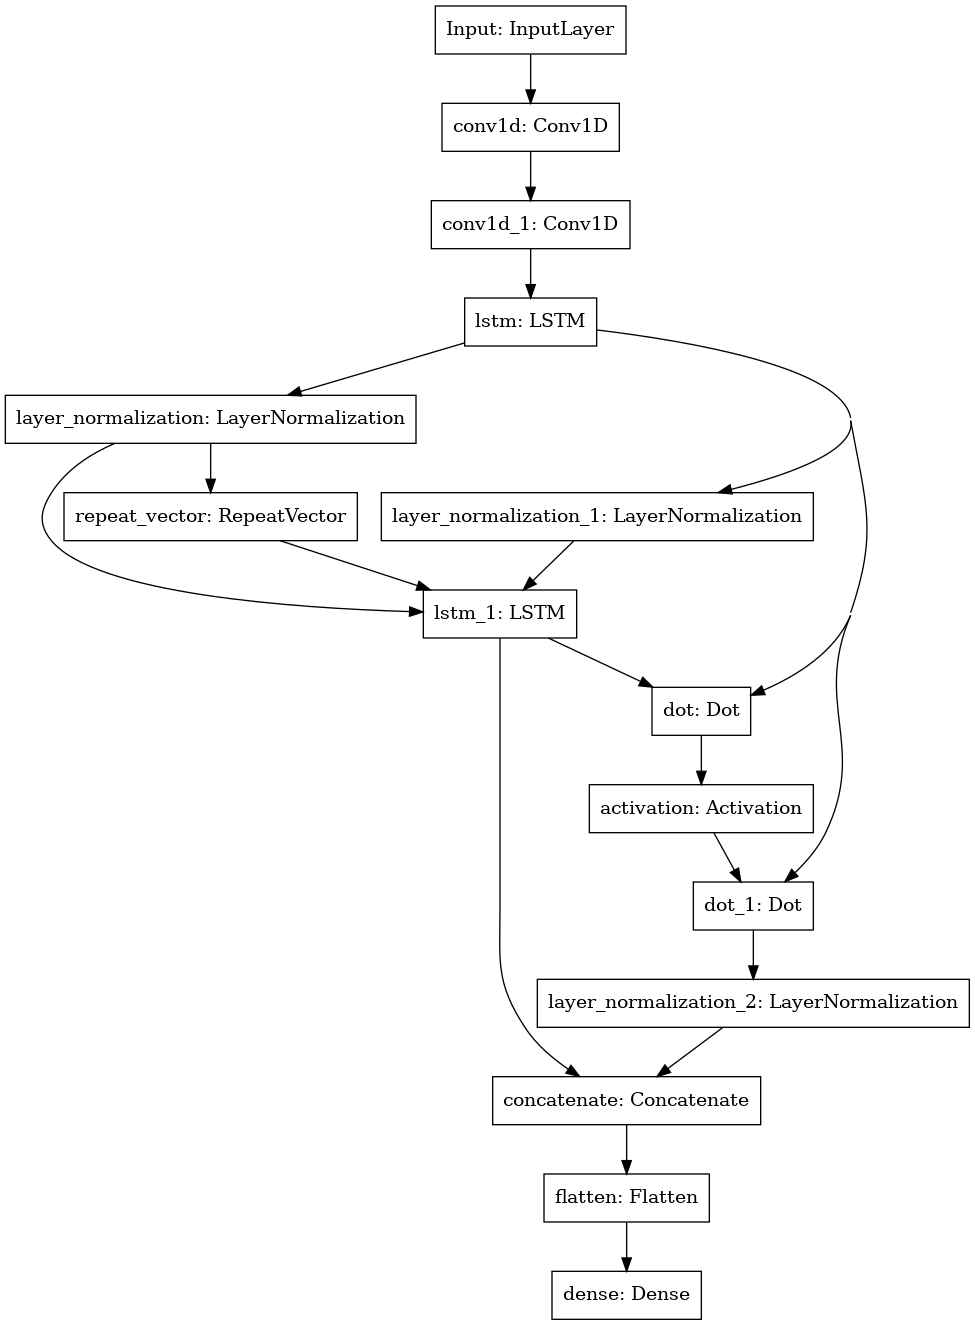

In [12]:
tfk.utils.plot_model(model, expand_nested=True)

In [13]:
future_window = 864

In [14]:
def autoregression_pred(model,window):
    last_window = train_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape

    pred = np.array([])
    X_temp = last_window
    for t in range(future_window):
        pred_temp = model.predict(X_temp)
        pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)
        
    pred_scaled = pred[0]*(train_max-train_min)+train_min
    return pred_scaled    


def compute_err(pred_scaled,return_values=True):
    rmse = np.sqrt(tfk.metrics.mse(test_raw[:future_window].flatten(),pred_scaled.flatten()))
    mae = (tfk.metrics.mae(test_raw[:future_window].flatten(),pred_scaled.flatten())).numpy()
    print("RMSE: " + str(rmse) + "  MAE: " + str(mae))
    if(return_values):
        return rmse,mae

In [15]:
pred_array = []
for i,model in enumerate(models_array):
    pred_array.append(autoregression_pred(model,sequence_length))

2022-01-17 13:14:05.758209: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [16]:
best_rmse = 1e7
best_model = 0

for i,pred in enumerate(pred_array):
    rmse,mae = compute_err(pred)
    if(rmse < best_rmse):
        best_rmse = rmse
        best_model = i
        
print("\nBest model is " + str(models_lables[best_model]))

RMSE: 10.46273631245132  MAE: 6.606199426378181

Best model is ConvLSTM Seq2Seq + Attention


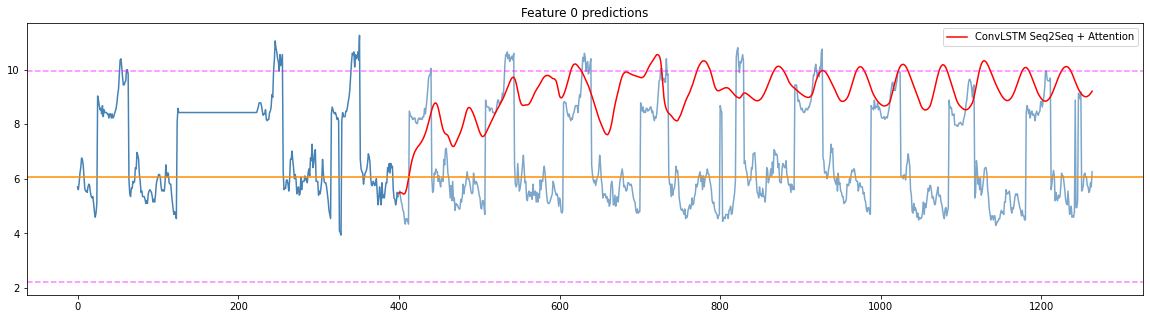

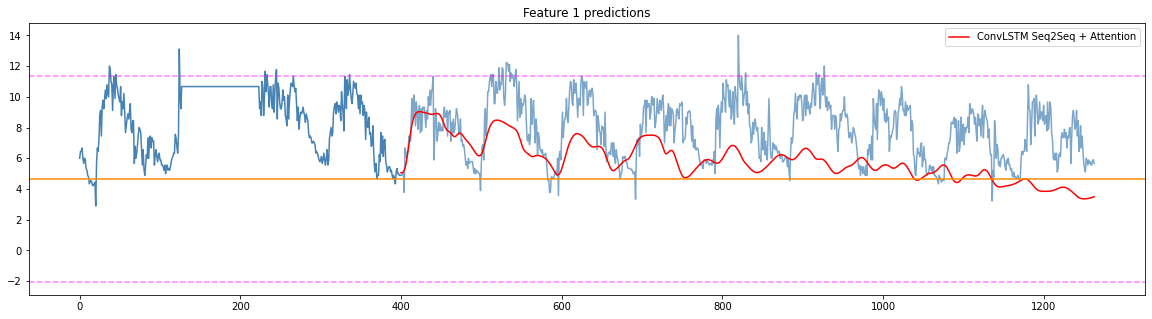

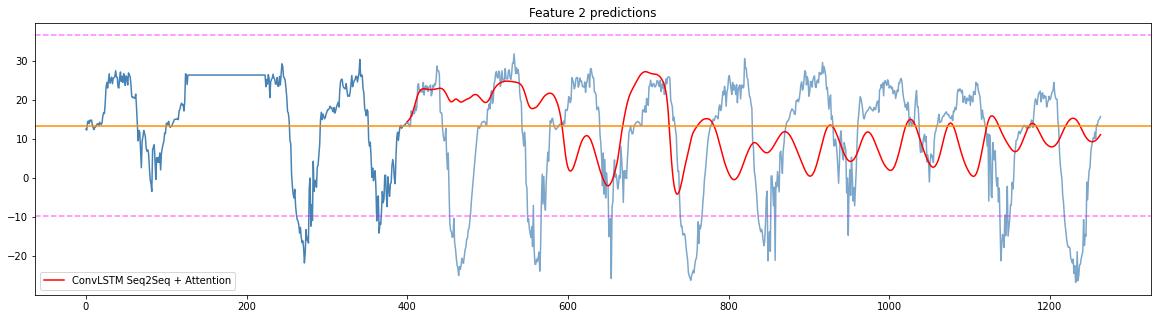

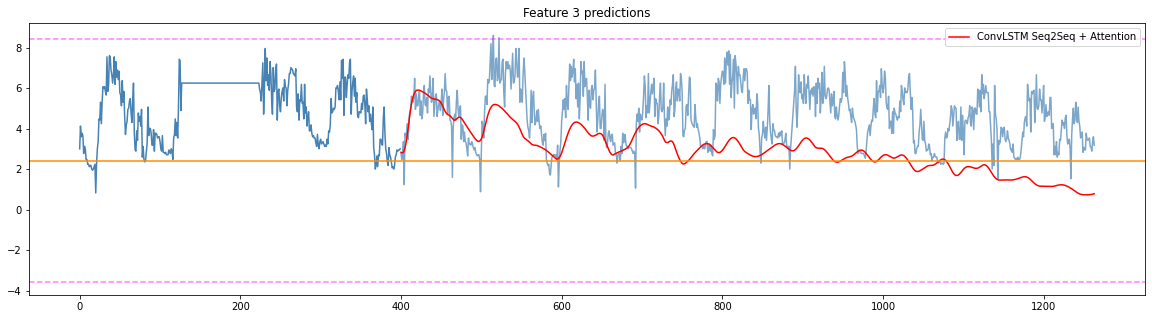

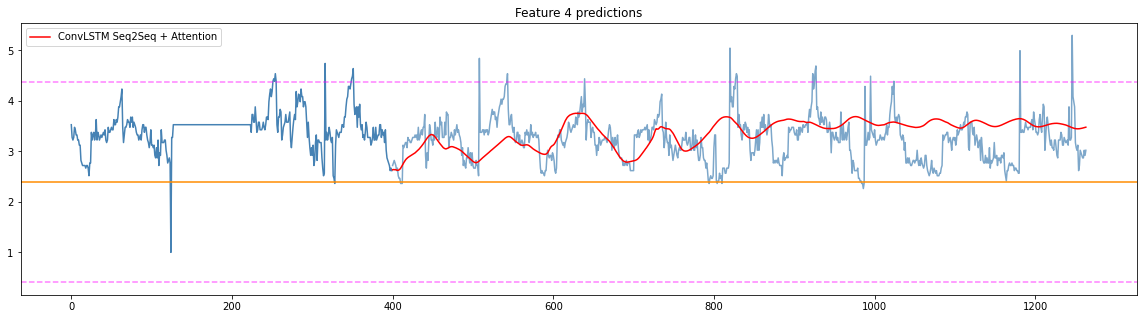

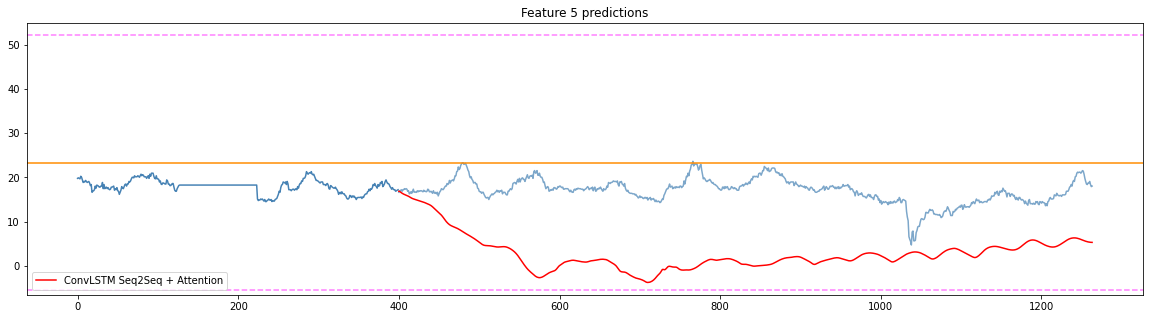

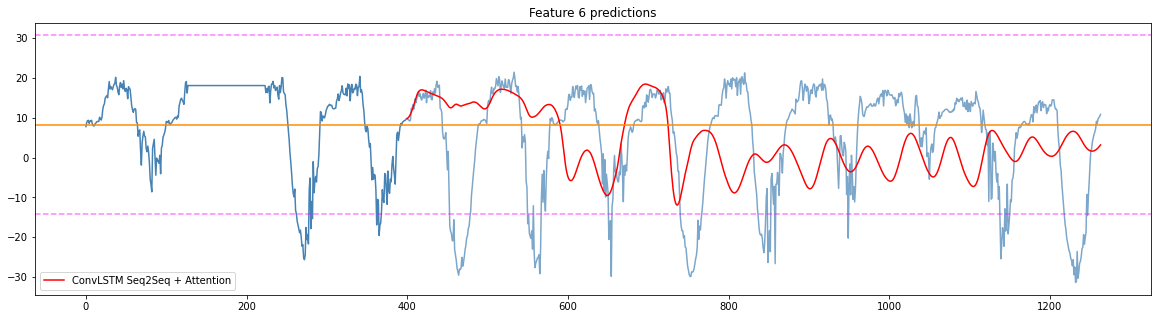

In [17]:
colors = ['#7d34fa','#fa34f3','#032cfc','#ff006f','#00ffd5','#62ff57']
window = sequence_length
for i in range(7):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),train_raw[-window:,i],color="steelblue")
    plt.plot(range(window,window+future_window),test_raw[:future_window,i],color="steelblue",alpha=.7)
    for j,pred in enumerate(pred_array):
        if(j!=best_model): 
            alpha_val = 0.35
            c = colors[j]
        else: 
            alpha_val = 1
            c = '#ff0000'
        plt.plot(range(window,window+future_window),pred[:,i],label=models_lables[j],alpha=alpha_val,color=c)
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.title('Feature ' + str(i) + ' predictions')
    plt.legend()


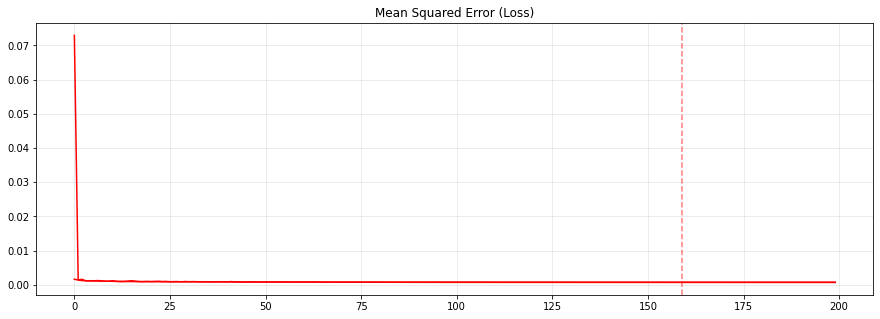

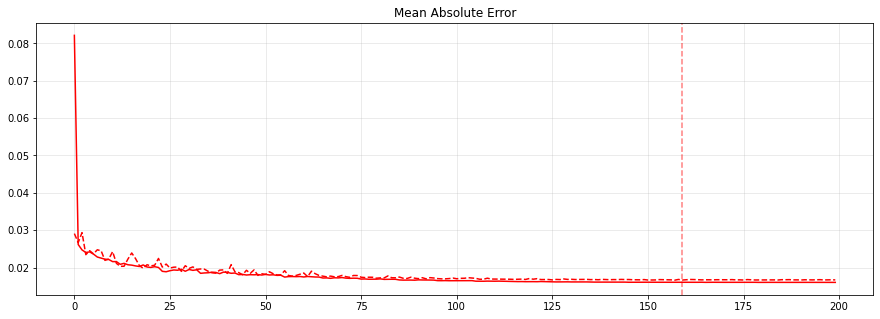

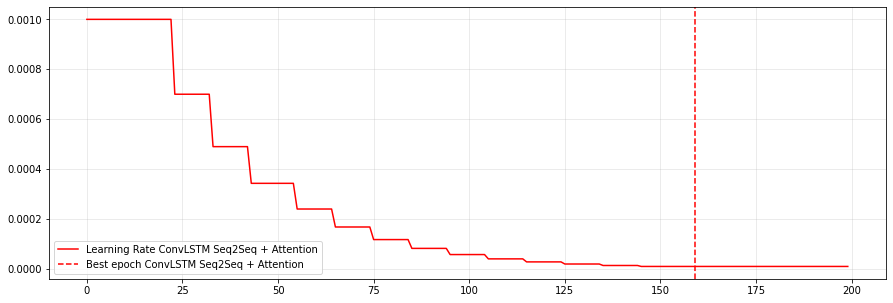

In [18]:
fig_size = (15,5)
plt.figure(figsize=fig_size)


for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['loss'], label='Training loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_loss'], label='Validation loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch ' + models_lables[i], alpha=.5, ls='--',color=c)

plt.title('Mean Squared Error (Loss)')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)

for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['mae'], label='Training accuracy '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_mae'], label='Validation accuracy '+ models_lables[i],alpha=alpha_val,ls='--',color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=.5, ls='--',color=c)
    
plt.title('Mean Absolute Error')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['lr'], label='Learning Rate '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=alpha_val, ls='--',color=c)

plt.legend()
plt.grid(alpha=.3)
plt.show()

In [19]:
import shutil
from os import path
def save_model(model,filename):
    model.save(filename)
    src = path.realpath(filename)
    root_dir, tail = path.split(src)
    shutil.make_archive(filename, 'zip', filename)
    print(filename + ' saved!')

In [20]:
for i,model in enumerate(models_array):
    save_model(model,models_lables[i])
#save_model(model_2,'model_2')

2022-01-17 13:17:55.759726: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ConvLSTM Seq2Seq + Attention saved!


In [21]:
#!rm -r model model.zip model_1 model_1.zip model_2 model_2.zip
#!zip -r model.zip model
#model = tfk.models.load_model('model')